In [1]:
import sys
!{sys.executable} -m pip install --quiet -r requirements.txt

In [2]:
from tqdm import tqdm_notebook as tqdm

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import numpy as np
#import cvxpy as cvx
import pandas as pd
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

In [6]:
import os
import project_helper
from zipline.data import bundles

os.environ['ZIPLINE_ROOT'] = os.path.join('/data', 'project_4_eod')

ingest_func = bundles.csvdir.csvdir_equities(['daily'], project_helper.EOD_BUNDLE_NAME)
bundles.register(project_helper.EOD_BUNDLE_NAME, ingest_func)

print('Data Registered')

Data Registered


In [7]:
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.utils.calendars import get_calendar


universe = AverageDollarVolume(window_length=120).top(500) 
trading_calendar = get_calendar('NYSE') 
bundle_data = bundles.load(project_helper.EOD_BUNDLE_NAME)
engine = project_helper.build_pipeline_engine(bundle_data, trading_calendar)

In [8]:
# Test
universe_end_date = pd.Timestamp('2016-01-05', tz='UTC')

universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()
    
universe_tickers[0:10]

[Equity(0 [A]),
 Equity(1 [AAL]),
 Equity(2 [AAP]),
 Equity(3 [AAPL]),
 Equity(4 [ABBV]),
 Equity(5 [ABC]),
 Equity(6 [ABT]),
 Equity(7 [ACN]),
 Equity(8 [ADBE]),
 Equity(9 [ADI])]

In [9]:
from zipline.data.data_portal import DataPortal

data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

# Make Factors


- Take the same factors we have been using:


In [10]:
from zipline.pipeline.factors import CustomFactor, DailyReturns, Returns, SimpleMovingAverage, AnnualizedVolatility
from zipline.pipeline.data import USEquityPricing

factor_start_date = universe_end_date - pd.DateOffset(years=3, days=2)
sector = project_helper.Sector()

def momentum_1yr(window_length, universe, sector):
    return Returns(window_length=window_length, mask=universe) \
        .demean(groupby=sector) \
        .rank() \
        .zscore()

def mean_reversion_5day_sector_neutral(window_length, universe, sector):
    return -Returns(window_length=window_length, mask=universe) \
        .demean(groupby=sector) \
        .rank() \
        .zscore()

def mean_reversion_5day_sector_neutral_smoothed(window_length, universe, sector):
    unsmoothed_factor = mean_reversion_5day_sector_neutral(window_length, universe, sector)
    return SimpleMovingAverage(inputs=[unsmoothed_factor], window_length=window_length) \
        .rank() \
        .zscore()

class CTO(Returns):
    """
    Computes the overnight return, per hypothesis from
    https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2554010
    """
    inputs = [USEquityPricing.open, USEquityPricing.close]
    
    def compute(self, today, assets, out, opens, closes):
        """
        The opens and closes matrix is 2 rows x N assets, with the most recent at the bottom.
        As such, opens[-1] is the most recent open, and closes[0] is the earlier close
        """
        out[:] = (opens[-1] - closes[0]) / closes[0]

        
class TrailingOvernightReturns(Returns):
    """
    Sum of trailing 1m O/N returns
    """
    window_safe = True
    
    def compute(self, today, asset_ids, out, cto):
        out[:] = np.nansum(cto, axis=0)

        
def overnight_sentiment(cto_window_length, trail_overnight_returns_window_length, universe):
    cto_out = CTO(mask=universe, window_length=cto_window_length)
    return TrailingOvernightReturns(inputs=[cto_out], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()

def overnight_sentiment_smoothed(cto_window_length, trail_overnight_returns_window_length, universe):
    unsmoothed_factor = overnight_sentiment(cto_window_length, trail_overnight_returns_window_length, universe)
    return SimpleMovingAverage(inputs=[unsmoothed_factor], window_length=trail_overnight_returns_window_length) \
        .rank() \
        .zscore()

universe = AverageDollarVolume(window_length=120).top(500)
sector = project_helper.Sector()

pipeline = Pipeline(screen=universe)
pipeline.add(
    momentum_1yr(252, universe, sector),
    'Momentum_1YR')
pipeline.add(
    mean_reversion_5day_sector_neutral_smoothed(20, universe, sector),
    'Mean_Reversion_Sector_Neutral_Smoothed')
pipeline.add(
    overnight_sentiment_smoothed(2, 10, universe),
    'Overnight_Sentiment_Smoothed')

#all_factors = engine.run_pipeline(pipeline, factor_start_date, universe_end_date)

#all_factors.head()


# Feature Engineering

- we include the 5-day return, b/c that's going to be the target

- Make "universal" quant features
  - Stock Volatility 20d, 120d
  - Stock Dollar Volume 20d, 120d
  
- Make regime features
    - Market Volatility 20d, 120d
    - Market Dispersion 20d, 120d
- Date parts:
  - Day of Week
  - End of Month
  - January
  - December



In [11]:
pipeline.add(AnnualizedVolatility(window_length=20, mask=universe).rank().zscore(), 'volatility_20d')
pipeline.add(AnnualizedVolatility(window_length=120, mask=universe).rank().zscore(), 'volatility_120d')
pipeline.add(AverageDollarVolume(window_length=20, mask=universe).rank().zscore(), 'adv_20d')
pipeline.add(AverageDollarVolume(window_length=120, mask=universe).rank().zscore(), 'adv_120d')
pipeline.add(sector, 'sector_code')


### Make Target

- We are going to try to predict the go forward 1-week return
- Very important! Quantize the target. Why do we do this?
  - Makes it market neutral return
  - Normalizes changing volatility and dispersion over time
- The factor we create is the trailing 5-day return; later we will shift it for training

In [12]:
pipeline.add(Returns(window_length=5, mask=universe).quantiles(2), 'return_5d')
pipeline.add(Returns(window_length=5, mask=universe).quantiles(25), 'return_5d_p')

### Make Regime Features
- We are going to try to capture market-wide regimes:
  - High and low volatility
  - High and low dispersion

In [13]:
class MarketDispersion(CustomFactor):
    inputs = [DailyReturns()]
    window_length = 1
    window_safe = True

    def compute(self, today, assets, out, returns):
        # returns are days in rows, assets across columns
        out[:] = np.sqrt(np.nanmean((returns - np.nanmean(returns))**2))
        
class MarketVolatility(CustomFactor):
    inputs = [DailyReturns()]
    window_length = 1
    window_safe = True
    
    def compute(self, today, assets, out, returns):
        mkt_returns = np.nanmean(returns, axis=1)
        out[:] = np.sqrt(260.* np.nanmean((mkt_returns-np.nanmean(mkt_returns))**2))

In [14]:
pipeline.add(SimpleMovingAverage(inputs=[MarketDispersion(mask=universe)], window_length=20), 'dispersion_20d')
pipeline.add(SimpleMovingAverage(inputs=[MarketDispersion(mask=universe)], window_length=120), 'dispersion_120d')
pipeline.add(MarketVolatility(window_length=20), 'market_vol_20d')
pipeline.add(MarketVolatility(window_length=120), 'market_vol_120d')

In [15]:
all_factors = engine.run_pipeline(pipeline, factor_start_date, universe_end_date)
all_factors.head()

Mean_Reversion_Sector_Neutral_Smoothed  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                                  -0.262769   
                          Equity(1 [AAL])                                 0.099926   
                          Equity(2 [AAP])                                 1.669138   
                          Equity(3 [AAPL])                                1.698746   
                          Equity(4 [ABBV])                                     NaN   

                                            Momentum_1YR  \
2013-01-03 00:00:00+00:00 Equity(0 [A])        -1.207978   
                          Equity(1 [AAL])       1.713471   
                          Equity(2 [AAP])      -1.535061   
                          Equity(3 [AAPL])      1.193111   
                          Equity(4 [ABBV])           NaN   

                                            Overnight_Sentiment_Smoothed  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                        -1.485669   
                          Equity(1 [AAL])                       0.919350   
                          Equity(2 [AAP])                       1.507733   
                          Equity(3 [AAPL])                     -1.367992   
                          Equity(4 [ABBV])                     -0.250063   

                                            adv_120d   adv_20d  \
2013-01-03 00:00:00+00:00 Equity(0 [A])     1.338573  1.397411   
                          Equity(1 [AAL])   1.139994  1.081155   
                          Equity(2 [AAP])  -0.301547 -0.919350   
                          Equity(3 [AAPL])  1.728377  1.728377   
                          Equity(4 [ABBV]) -1.728377 -1.647475   

                                            dispersion_120d  dispersion_20d  \
2013-01-03 00:00:00+00:00 Equity(0 [A])            0.013270        0.011178   
                          Equity(1 [AAL])          0.013270        0.011178   
                          Equity(2 [AAP])          0.013270        0.011178   
                          Equity(3 [AAPL])         0.013270        0.011178   
                          Equity(4 [ABBV])         0.014595        0.014595   

                                            market_vol_120d  market_vol_20d  \
2013-01-03 00:00:00+00:00 Equity(0 [A])            0.129664        0.137586   
                          Equity(1 [AAL])          0.129664        0.137586   
                          Equity(2 [AAP])          0.129664        0.137586   
                          Equity(3 [AAPL])         0.129664        0.137586   
                          Equity(4 [ABBV])         0.129664        0.137586   

                                            return_5d  return_5d_p  \
2013-01-03 00:00:00+00:00 Equity(0 [A])             0            2   
                          Equity(1 [AAL])           1           22   
                          Equity(2 [AAP])           0           10   
                          Equity(3 [AAPL])          1           24   
                          Equity(4 [ABBV])         -1           -1   

                                            sector_code  volatility_120d  \
2013-01-03 00:00:00+00:00 Equity(0 [A])               0        -0.836546   
                          Equity(1 [AAL])             3         1.639924   
                          Equity(2 [AAP])             8         1.072400   
                          Equity(3 [AAPL])            1         1.050289   
                          Equity(4 [ABBV])            0              NaN   

                                            volatility_20d  
2013-01-03 00:00:00+00:00 Equity(0 [A])          -1.219809  
                          Equity(1 [AAL])         1.566220  
                          Equity(2 [AAP])        -1.470404  
                          Equity(3 [AAPL])        1.617813  
                          Equity(4 [ABBV])             NaN

In [16]:
len(all_factors.reset_index(level=1).loc['2013-01-03'])

471

### Make Date Parts
- we make colums to for the trees to split on that might capture trader/investor behavior due to calendar anomalies

In [17]:
all_factors['is_Janaury'] = all_factors.index.get_level_values(0).month == 1
all_factors['is_December'] = all_factors.index.get_level_values(0).month == 12
all_factors['weekday'] = all_factors.index.get_level_values(0).weekday
all_factors['quarter'] = all_factors.index.get_level_values(0).quarter
all_factors['year'] = all_factors.index.get_level_values(0).year
all_factors['qtr_yr'] = all_factors.quarter.astype('str') + '_' + all_factors.year.astype('str')
all_factors['month_end'] = all_factors.index.get_level_values(0).isin(pd.date_range(start=factor_start_date, end=universe_end_date, freq='BM'))
all_factors['month_start'] = all_factors.index.get_level_values(0).isin(pd.date_range(start=factor_start_date, end=universe_end_date, freq='BMS'))
all_factors['qtr_end'] = all_factors.index.get_level_values(0).isin(pd.date_range(start=factor_start_date, end=universe_end_date, freq='BQ'))
all_factors['qtr_start'] = all_factors.index.get_level_values(0).isin(pd.date_range(start=factor_start_date, end=universe_end_date, freq='BQS'))
del all_factors['year']

In [18]:
all_factors.head()

Mean_Reversion_Sector_Neutral_Smoothed  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                                  -0.262769   
                          Equity(1 [AAL])                                 0.099926   
                          Equity(2 [AAP])                                 1.669138   
                          Equity(3 [AAPL])                                1.698746   
                          Equity(4 [ABBV])                                     NaN   

                                            Momentum_1YR  \
2013-01-03 00:00:00+00:00 Equity(0 [A])        -1.207978   
                          Equity(1 [AAL])       1.713471   
                          Equity(2 [AAP])      -1.535061   
                          Equity(3 [AAPL])      1.193111   
                          Equity(4 [ABBV])           NaN   

                                            Overnight_Sentiment_Smoothed  \
2013-01-03 00:00:00+00:00 Equity(0 [A])                        -1.485669   
                          Equity(1 [AAL])                       0.919350   
                          Equity(2 [AAP])                       1.507733   
                          Equity(3 [AAPL])                     -1.367992   
                          Equity(4 [ABBV])                     -0.250063   

                                            adv_120d   adv_20d  \
2013-01-03 00:00:00+00:00 Equity(0 [A])     1.338573  1.397411   
                          Equity(1 [AAL])   1.139994  1.081155   
                          Equity(2 [AAP])  -0.301547 -0.919350   
                          Equity(3 [AAPL])  1.728377  1.728377   
                          Equity(4 [ABBV]) -1.728377 -1.647475   

                                            dispersion_120d  dispersion_20d  \
2013-01-03 00:00:00+00:00 Equity(0 [A])            0.013270        0.011178   
                          Equity(1 [AAL])          0.013270        0.011178   
                          Equity(2 [AAP])          0.013270        0.011178   
                          Equity(3 [AAPL])         0.013270        0.011178   
                          Equity(4 [ABBV])         0.014595        0.014595   

                                            market_vol_120d  market_vol_20d  \
2013-01-03 00:00:00+00:00 Equity(0 [A])            0.129664        0.137586   
                          Equity(1 [AAL])          0.129664        0.137586   
                          Equity(2 [AAP])          0.129664        0.137586   
                          Equity(3 [AAPL])         0.129664        0.137586   
                          Equity(4 [ABBV])         0.129664        0.137586   

                                            return_5d    ...     \
2013-01-03 00:00:00+00:00 Equity(0 [A])             0    ...      
                          Equity(1 [AAL])           1    ...      
                          Equity(2 [AAP])           0    ...      
                          Equity(3 [AAPL])          1    ...      
                          Equity(4 [ABBV])         -1    ...      

                                            volatility_20d  is_Janaury  \
2013-01-03 00:00:00+00:00 Equity(0 [A])          -1.219809        True   
                          Equity(1 [AAL])         1.566220        True   
                          Equity(2 [AAP])        -1.470404        True   
                          Equity(3 [AAPL])        1.617813        True   
                          Equity(4 [ABBV])             NaN        True   

                                            is_December  weekday quarter  \
2013-01-03 00:00:00+00:00 Equity(0 [A])           False        3       1   
                          Equity(1 [AAL])         False        3       1   
                          Equity(2 [AAP])         False        3       1   
                          Equity(3 [AAPL])        False        3       1   
                          Equity(4 [ABBV])        False        3       1   

                                            qtr_yr  month

### Shift Target
- Note I am going to create a bunch of other shifts to show these are not IID

In [19]:
all_factors['target'] = all_factors.groupby(level=1)['return_5d'].shift(-5)
all_factors['target_p'] = all_factors.groupby(level=1)['return_5d_p'].shift(-5)
all_factors['target_1'] = all_factors.groupby(level=1)['return_5d'].shift(-4)
all_factors['target_2'] = all_factors.groupby(level=1)['return_5d'].shift(-3)
all_factors['target_3'] = all_factors.groupby(level=1)['return_5d'].shift(-2)
all_factors['target_4'] = all_factors.groupby(level=1)['return_5d'].shift(-1)


In [20]:
# confirm we did the shift correctly
all_factors[['return_5d','target', 'target_1']].reset_index().sort_values(['level_1', 'level_0']).head(10)

,level_0,level_1,return_5d,target,target_1
0,2013-01-03 00:00:00+00:00,Equity(0 [A]),0,0.0,0.0
471,2013-01-04 00:00:00+00:00,Equity(0 [A]),0,0.0,0.0
942,2013-01-07 00:00:00+00:00,Equity(0 [A]),0,0.0,0.0
1413,2013-01-08 00:00:00+00:00,Equity(0 [A]),0,1.0,0.0
1884,2013-01-09 00:00:00+00:00,Equity(0 [A]),0,0.0,1.0
2355,2013-01-10 00:00:00+00:00,Equity(0 [A]),0,0.0,0.0
2826,2013-01-11 00:00:00+00:00,Equity(0 [A]),0,0.0,0.0
3297,2013-01-14 00:00:00+00:00,Equity(0 [A]),0,0.0,0.0
3768,2013-01-15 00:00:00+00:00,Equity(0 [A]),1,0.0,0.0
4239,2013-01-16 00:00:00+00:00,Equity(0 [A]),0,0.0,0.0


# Sidebar: IID Check of Target
- Look at autocorrelation of the target, what do you observe?

In [21]:
from scipy.stats import spearmanr

def sp(group, col1_name, col2_name):
    x = group[col1_name]
    y = group[col2_name]
    return spearmanr(x, y)[0]

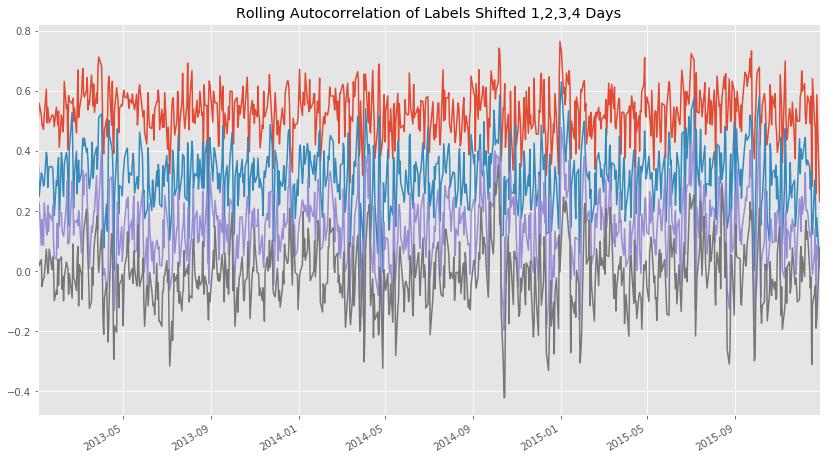

In [22]:
g = all_factors.dropna().groupby(level=0)
for i in range(4):
    ic = g.apply(sp, 'target', 'target_'+str(i+1))
    ic.plot();
plt.title('Rolling Autocorrelation of Labels Shifted 1,2,3,4 Days');

So this looks very bad! Today's label is very highly correlated to tomorrow's label; today's label is highly correlated to the day after tomorrow, etc.

# Make Train/Valid/Test splits
- We always want three cuts:
  - Test: this is some data we take and stick somewhere and **never** look at it until the end
  - Validation: this is data we use to tune hyperparameters and get our best understanding of if the model is working
  - Train: this is data we train the model on

In [23]:
features = [
    'Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR',
    'Overnight_Sentiment_Smoothed', 'adv_120d', 'adv_20d',
    'dispersion_120d', 'dispersion_20d', 'market_vol_120d',
    'market_vol_20d', 'volatility_20d',
    'is_Janaury', 'is_December', 'weekday',
    'month_end', 'month_start', 'qtr_end', 'qtr_start',
    'sector_code'
]

target_label = 'target'

Make our splits

In [24]:
def make_splits(df, features, target, split_valid=0.20, split_test=0.20):
    temp = df.dropna()
    X = temp[features].copy()
    y = temp[target].copy()

    train_end = int(X.shape[0]*(1-split_valid-split_test))
    valid_end = train_end + int(X.shape[0]*split_valid)

    X_train, X_valid, X_test = X.iloc[:train_end,], X.iloc[(train_end+1):valid_end,], X.iloc[(valid_end+1):]
    y_train, y_valid, y_test = y.iloc[:train_end,], y.iloc[(train_end+1):valid_end,], y.iloc[(valid_end+1):]
    
    return X, X_train, X_valid, X_test, y_train, y_valid, y_test

In [25]:
X, X_train, X_valid, X_test, y_train, y_valid, y_test = make_splits(
    all_factors.reset_index(drop=True),
    features,
    target_label
)

In [26]:
X_train.tail()

,Mean_Reversion_Sector_Neutral_Smoothed,Momentum_1YR,Overnight_Sentiment_Smoothed,adv_120d,adv_20d,dispersion_120d,dispersion_20d,market_vol_120d,market_vol_20d,volatility_20d,is_Janaury,is_December,weekday,month_end,month_start,qtr_end,qtr_start,sector_code
216478,0.195263,0.747017,0.616798,0.573765,0.480529,0.011441,0.013175,0.110008,0.196184,1.255112,False,False,2,False,False,False,False,5
216479,-1.374073,1.105878,-1.283800,0.322743,0.695691,0.011441,0.013175,0.110008,0.196184,1.011262,False,False,2,False,False,False,False,1
216480,-0.491773,0.175769,0.609626,-1.176219,-1.233596,0.011441,0.013175,0.110008,0.196184,-1.154703,False,False,2,False,False,False,False,4
216481,-0.376062,1.039965,1.269456,0.121925,-0.136269,0.011441,0.013175,0.110008,0.196184,-1.699780,False,False,2,False,False,False,False,4
216482,1.569335,-1.501358,-0.207990,-1.061466,-1.154703,0.011441,0.013175,0.110008,0.196184,-0.358603,False,False,2,False,False,False,False,4


In [27]:
X_valid.head()

,Mean_Reversion_Sector_Neutral_Smoothed,Momentum_1YR,Overnight_Sentiment_Smoothed,adv_120d,adv_20d,dispersion_120d,dispersion_20d,market_vol_120d,market_vol_20d,volatility_20d,is_Janaury,is_December,weekday,month_end,month_start,qtr_end,qtr_start,sector_code
216484,0.491773,-1.391503,-0.681346,-0.057377,0.114753,0.011441,0.013175,0.110008,0.196184,-1.290972,False,False,2,False,False,False,False,5
216485,-0.932923,1.589243,-0.631142,1.477446,1.470274,0.011441,0.013175,0.110008,0.196184,1.161875,False,False,2,False,False,False,False,0
216486,1.214969,-0.659133,-0.164958,1.355521,1.398553,0.011441,0.013175,0.110008,0.196184,-0.014344,False,False,2,False,False,False,False,5
216487,0.347134,0.541954,1.319661,-1.613715,-1.642404,0.011441,0.013175,0.110008,0.196184,-1.305316,False,False,2,False,False,False,False,6
216488,0.448382,0.285624,-0.509217,-1.570683,-1.635232,0.011441,0.013175,0.110008,0.196184,-0.645486,False,False,2,False,False,False,False,5


# Make and Visualize a Single Tree

Let's see how a single tree would look. This is to get some intuition as to what is happening.

In [28]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, ExtraTreesRegressor, RandomForestRegressor
from sklearn.metrics import log_loss

In [29]:
clf = RandomForestClassifier(
    n_estimators=1,
    max_depth=3,
    max_features=None,
    bootstrap=False,
    oob_score=False,
    criterion='entropy',
    random_state=0
)

In [30]:
%time clf.fit(X_train.values, y_train)

CPU times: user 1.03 s, sys: 406 ms, total: 1.43 s
Wall time: 1.02 s


RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=3, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [31]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(
    clf.estimators_[0],
    out_file=None,
    feature_names=features,
    filled=True, rounded=True,
    special_characters=True,
    rotate=True
)
graphviz.Source(dot_data, filename='tmp', format='png').view();

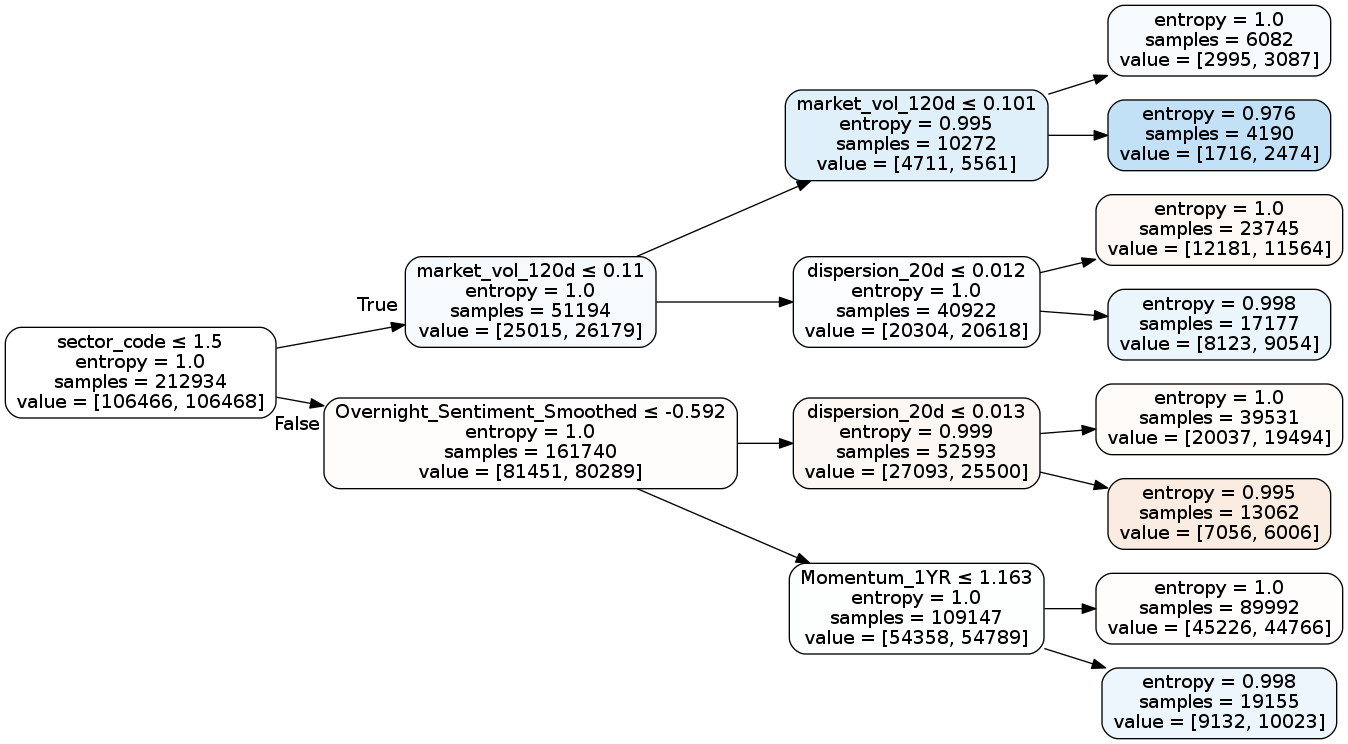

In [32]:
from IPython.display import Image
Image('tmp.png')

So what is the story you can craft here? What does the model think about these features and their interactions?

# Fit Random Forest

- Check OOB score vs Validation Score (should observe overfitting?)

In [33]:
def model_score(m):
    train_score = m.score(X_train, y_train)
    valid_score = m.score(X_valid, y_valid)
    oob_score = m.oob_score_
    print("train: %f, oob: %f, valid: %f" % (train_score, oob_score, valid_score))
    return train_score, valid_score, oob_score

In [34]:
def model_importances(m, features):
    importances = m.feature_importances_
    indices = np.argsort(importances)[::-1]
    for f in range(X_train.shape[1]):
        print("%d. %s (%d) (%f)" % (f+1,features[indices[f]], indices[f], importances[indices[f]]))

In [35]:
import psutil


In [36]:
psutil.cpu_count()

8

In [37]:
psutil.virtual_memory().total / (1024.0 ** 3)

29.445232391357422

In [38]:
train_score = []
valid_score = []
oob_score = []
tree_sizes = [10, 50, 100, 250, 500, 1000]
#tree_sizes = [10, 50, 100]

for trees in tqdm(tree_sizes):
    clf = RandomForestClassifier(
        n_estimators=trees,
        max_features='sqrt',
        #min_samples_leaf=5000,
        min_samples_split=10000,
        bootstrap=True,
        oob_score=True,
        n_jobs=-1,
        criterion='entropy',
        verbose=0,
        random_state=0
    )
    clf.fit(X_train, y_train)
    t, v, o = model_score(clf)
    train_score.append(t); valid_score.append(v); oob_score.append(o)


HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

train: 0.552124, oob: 0.528042, valid: 0.509729
train: 0.560427, oob: 0.542741, valid: 0.512899
train: 0.562583, oob: 0.545178, valid: 0.510940
train: 0.564687, oob: 0.549320, valid: 0.510757
train: 0.564799, oob: 0.549541, valid: 0.510588
train: 0.565574, oob: 0.550062, valid: 0.509926



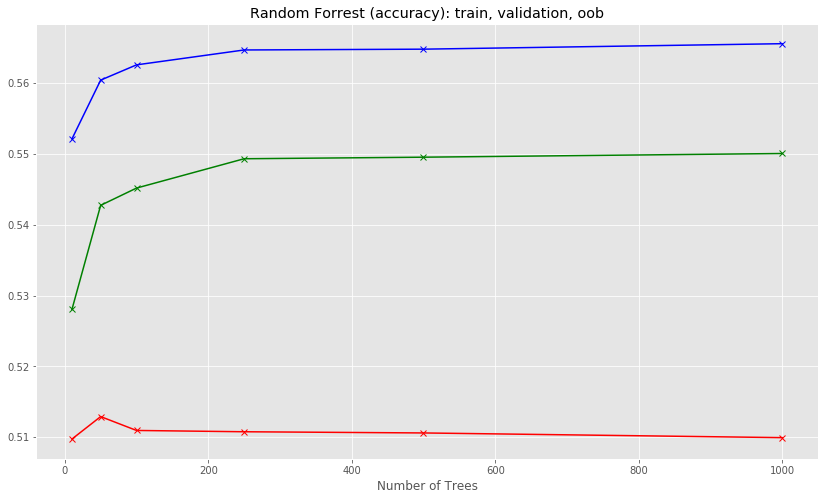

In [39]:
plt.plot(tree_sizes, train_score, 'xb-');
plt.plot(tree_sizes, oob_score, 'xg-');
plt.plot(tree_sizes, valid_score, 'xr-');
plt.title('Random Forrest (accuracy): train, validation, oob');
plt.xlabel('Number of Trees');

In [40]:
model_importances(clf, features)

1. dispersion_20d (6) (0.118380)
2. market_vol_120d (7) (0.118020)
3. dispersion_120d (5) (0.103769)
4. volatility_20d (9) (0.100960)
5. market_vol_20d (8) (0.097362)
6. sector_code (17) (0.093241)
7. Momentum_1YR (1) (0.076063)
8. adv_120d (3) (0.074227)
9. Mean_Reversion_Sector_Neutral_Smoothed (0) (0.063662)
10. adv_20d (4) (0.062417)
11. Overnight_Sentiment_Smoothed (2) (0.051376)
12. is_December (11) (0.024614)
13. qtr_start (16) (0.004654)
14. weekday (12) (0.003762)
15. is_Janaury (10) (0.002895)
16. month_start (14) (0.002602)
17. month_end (13) (0.001236)
18. qtr_end (15) (0.000761)


What do we observe from the RF run?

1. Validation accuracy is just a bit greater than 51%; this seems low; is this good? takeaway: **let's look at the simulated return of the alpha vector and see!**

2. After a few hundred trees we don't get any improvement in accuracy score; takeaway: **we would want to limit trees to this size to reduce compute time**
3. The OOB score is significantly over-optimistic; **we are not gettig consistency between train/valid/oob**. takeaway: **we need to improve the sampling (IID issue) such that OOB is closer to validation**
4. In feature importances, sector code is important. takeaway: **This is a categorical variable; as such, we should explore if OHE will do a better job.**
5. The low frequency date parts are not important. This should not be surprising since we are looking at only a couple ears of training history and there are only, say, 4 quarters in year. Takeaway: **remove these factors from the final model or modify them to be, say, a longer window of time (e.g., "last two weeks of quarter").**

Before we do that, for fun, we can investigate what a single tree looks like:

In [41]:
dot_data = export_graphviz(
    clf.estimators_[1],
    out_file=None,
    feature_names=features,
    filled=True, rounded=True,
    special_characters=True,
    rotate=True
)
graphviz.Source(dot_data, filename='tmp3', format='png').view();

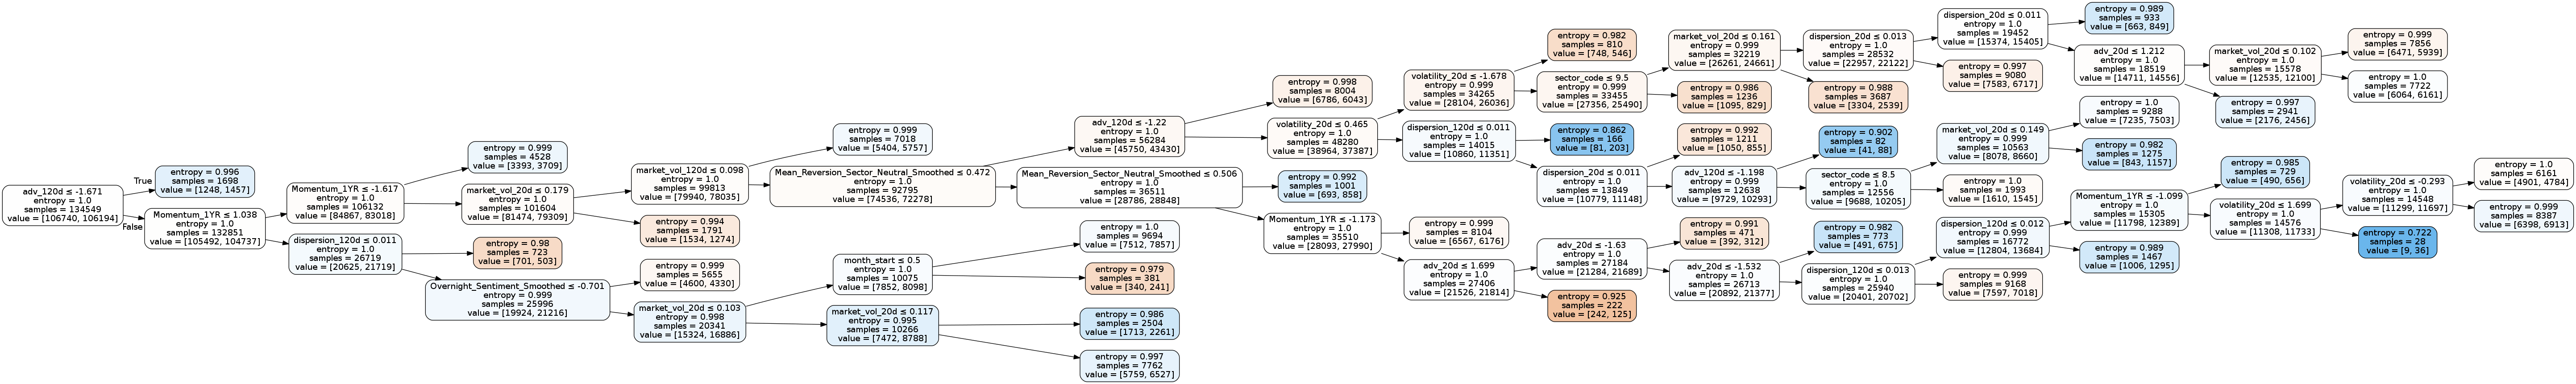

In [42]:
Image('tmp3.png')

### Combined Alpha Vector Return, version 1

- **Very important** - we want the probability weighted class prediction, not the binary class prediction. Why? The binary class prediction is just {0,1}; back to the definition of an alpha vector: value is proportional to future returns. A vector of real numbers is better and the probability weighted prediction achieves this.

In [43]:
import alphalens as al

assets = all_factors.index.levels[1].values.tolist()
pricing = get_pricing(
    data_portal,
    trading_calendar,
    assets,
    factor_start_date,
    universe_end_date
)

In [44]:
def format_data(factor_df, pricing):
    clean_factor_data = {
        factor: al.utils.get_clean_factor_and_forward_returns(factor=factor_data, prices=pricing, periods=[1])
        for factor, factor_data in factor_df.iteritems()}

    unixt_factor_data = {
        factor: factor_data.set_index(pd.MultiIndex.from_tuples(
            [(x.timestamp(), y) for x, y in factor_data.index.values],
            names=['date', 'asset']))
        for factor, factor_data in clean_factor_data.items()}
    
    return clean_factor_data, unixt_factor_data

def sharpe_ratio(factor_returns, annualization_factor):
    return annualization_factor * factor_returns.mean() / factor_returns.std()

In [45]:
def make_model_OOS_plots(all_factor_data, out_of_sample_data, classifier, other_factors, pricing=pricing,
                        prob_array=[-1,1]):

    preds_prob = classifier.predict_proba(out_of_sample_data)
    alpha_score = preds_prob.dot(np.array(prob_array))
    s = pd.DataFrame(index=out_of_sample_data.index, data=alpha_score, columns=['AI_ALPHA'])
    result = pd.concat([all_factors.reset_index(), s], axis=1, join='inner').set_index(['level_0', 'level_1'])
    other_factors = other_factors + ['AI_ALPHA']
    clean_factor_data, unixt_factor_data = format_data(
        result[other_factors],
        pricing
    )
    ls_factor_returns = pd.DataFrame()

    for factor, factor_data in clean_factor_data.items():
        ls_factor_returns[factor] = al.performance.factor_returns(factor_data).iloc[:, 0]
    (1+ls_factor_returns).cumprod().plot();
    
    daily_annualization_factor = np.sqrt(252)
    print(sharpe_ratio(ls_factor_returns, daily_annualization_factor).round(2))
    
    ls_FRA = pd.DataFrame()

    for factor, factor_data in unixt_factor_data.items():
        ls_FRA[factor] = al.performance.factor_rank_autocorrelation(factor_data)

    ls_FRA.plot(title="Factor Rank Autocorrelation")

### In-Sample Training Prediction

Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% en

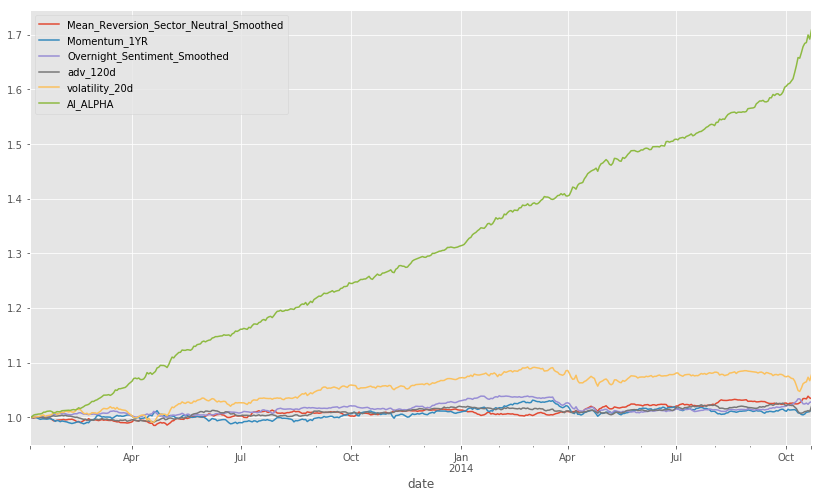

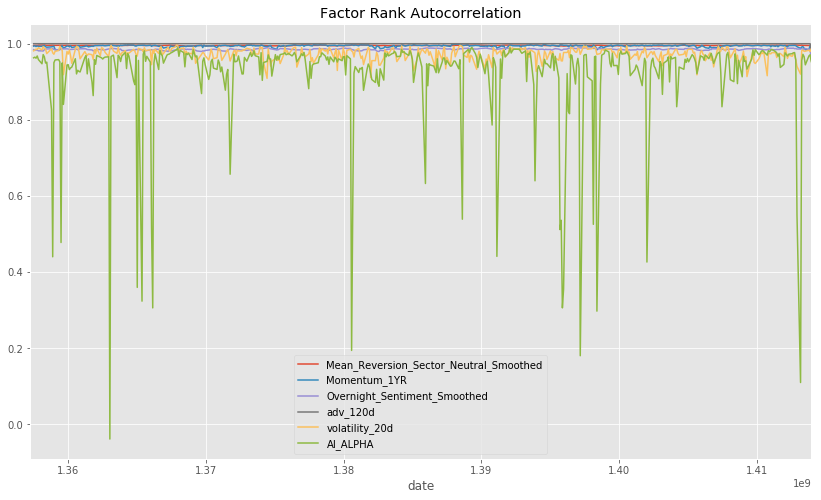

In [46]:
factor_names = ['Mean_Reversion_Sector_Neutral_Smoothed','Momentum_1YR',
            'Overnight_Sentiment_Smoothed', 'adv_120d', 'volatility_20d']

make_model_OOS_plots(all_factors, X_train, clf, factor_names)

### And Validation v1 Prediction

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% en

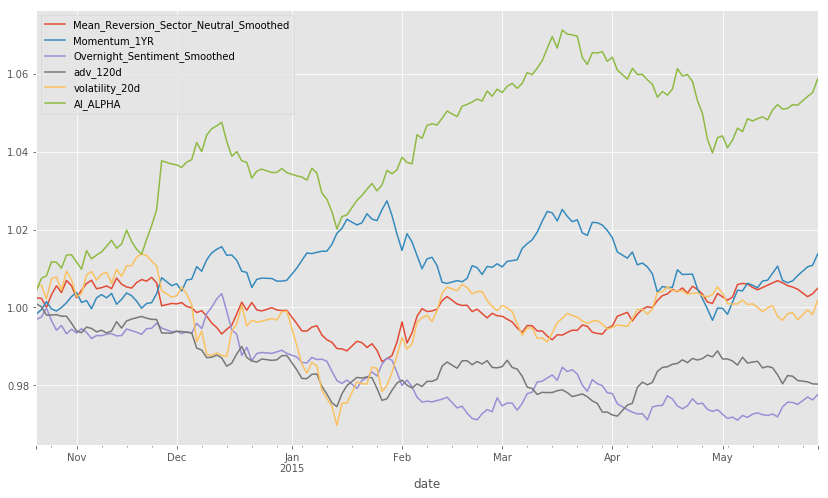

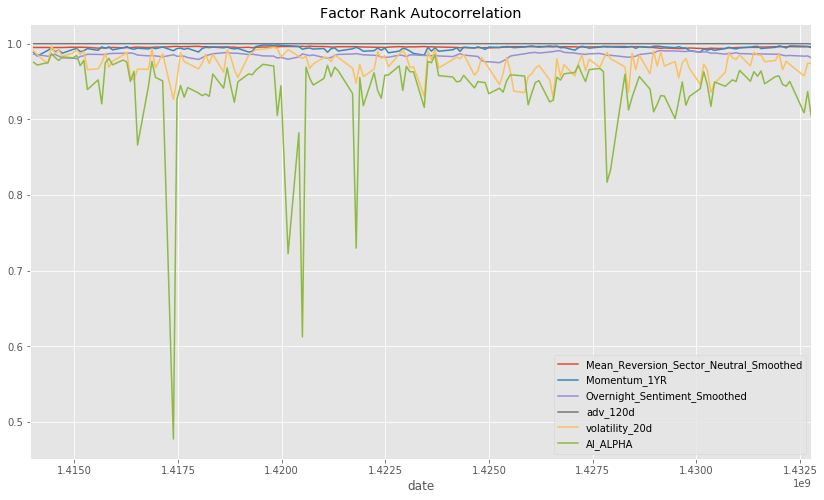

In [47]:
make_model_OOS_plots(all_factors, X_valid, clf, factor_names)

So that's pretty extraordinary IMHO. Even when the input factor returns are sideways to down, the AI Alpha is positive with Sharpe Ratio > 2. If we hope that this model will perform well in production we need to correct though for the non-IID labels and mitigate likely overfitting.

# Overlapping Samples

We can do a number of things:

1) don't use overlapping samples

2) Sample, but set the `max_samples` to be on the order of the average uniqueness of the labels (and ramp up the number of trees). `RandomForrestClassifier` does not take this param, but `BaggingClassifier` does. "We enforce that in-bag observations are not sampled at a frequency much higher than their uniqueness." -LdP 4.5

3) build an ensemble of non-overlapping trees


## 1. Don't Use Overlapping Samples

In [48]:
train_score = []
valid_score = []
oob_score = []
tree_sizes = [10, 50, 100, 250, 500, 1000]
#tree_sizes = [10, 50, 100]

for trees in tqdm(tree_sizes):
    clf = RandomForestClassifier(
        n_estimators=trees,
        max_features='sqrt',
        #min_samples_leaf=5000,
        min_samples_split=10000,
        bootstrap=True,
        oob_score=True,
        n_jobs=-1,
        criterion='entropy',
        verbose=0,
        random_state=0
    )
    clf.fit(X_train[::5], y_train[::5])   # Note the incremental slicing!
    t, v, o = model_score(clf)
    train_score.append(t); valid_score.append(v); oob_score.append(o)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

train: 0.511370, oob: 0.502947, valid: 0.495541
train: 0.514967, oob: 0.507995, valid: 0.501036
train: 0.516179, oob: 0.511424, valid: 0.500993
train: 0.517057, oob: 0.511682, valid: 0.501120
train: 0.517470, oob: 0.512621, valid: 0.503487
train: 0.518100, oob: 0.513161, valid: 0.502726



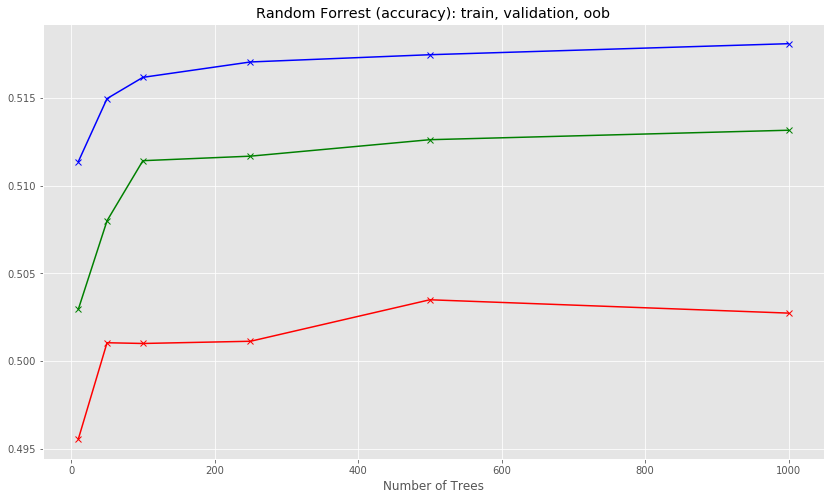

In [49]:
plt.plot(tree_sizes, train_score, 'xb-');
plt.plot(tree_sizes, oob_score, 'xg-');
plt.plot(tree_sizes, valid_score, 'xr-');
plt.title('Random Forrest (accuracy): train, validation, oob');
plt.xlabel('Number of Trees');

This looks better, but we are throwing away a lot of information by taking every 5th row.

## 2. Use `max_samples` param

In [50]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [51]:
base_clf = DecisionTreeClassifier(
    criterion='entropy',
    max_features='sqrt',
    #min_samples_leaf=5000
    min_samples_split=10000
)

In [52]:
train_score = []
valid_score = []
oob_score = []
tree_sizes = [10, 50, 100, 250, 500, 1000]
#tree_sizes = [10, 50, 100]

for trees in tqdm(tree_sizes):
    clf = BaggingClassifier(
        base_estimator=base_clf,
        n_estimators=trees,
        max_samples=0.2,
        max_features=1.,
        oob_score=True,
        n_jobs=-1,
        random_state=0
    )
    clf.fit(X_train, y_train)   # Note the incremental slicing!
    t, v, o = model_score(clf)
    train_score.append(t); valid_score.append(v); oob_score.append(o)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

train: 0.519640, oob: 0.512854, valid: 0.503769
train: 0.526060, oob: 0.518015, valid: 0.506108
train: 0.528784, oob: 0.520542, valid: 0.507784
train: 0.529239, oob: 0.520776, valid: 0.508193
train: 0.530343, oob: 0.520983, valid: 0.508615
train: 0.530972, oob: 0.522589, valid: 0.508770



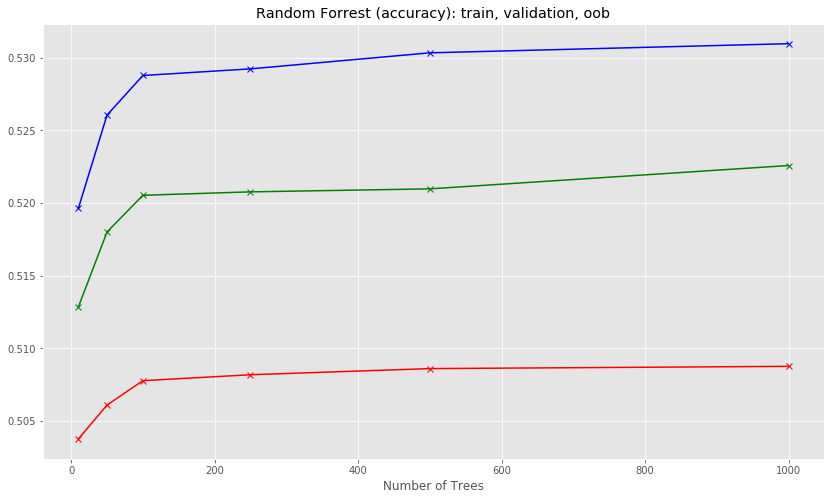

In [53]:
plt.plot(tree_sizes, train_score, 'xb-');
plt.plot(tree_sizes, oob_score, 'xg-');
plt.plot(tree_sizes, valid_score, 'xr-');
plt.title('Random Forrest (accuracy): train, validation, oob');
plt.xlabel('Number of Trees');

This seems much "better" in the sense that we have much better fidelity between the three.


Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% en

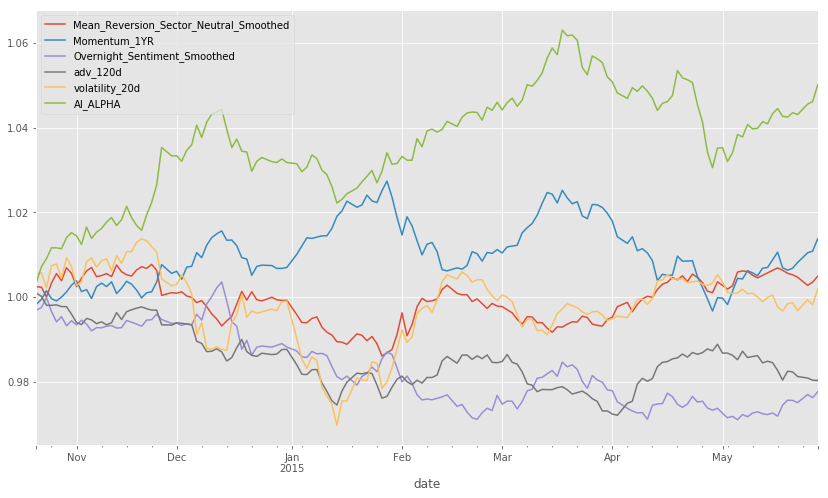

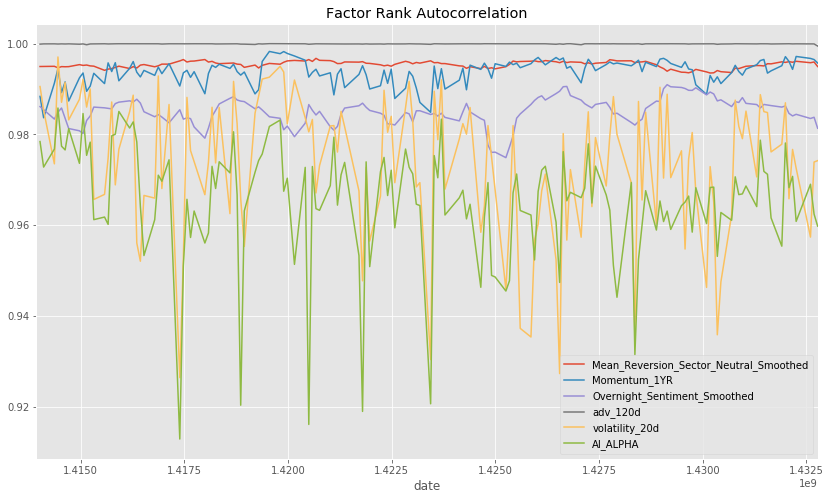

In [54]:
make_model_OOS_plots(all_factors, X_valid, clf, factor_names)

## Bagged Non-Overlapping Classifiers

Here we are going to write a custom `scikit-learn` estimator. We inherit from `VotingClassifier` and we override the `fit` method so we fit on **non-overlapping** periods.

In [55]:
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.validation import has_fit_parameter, check_is_fitted
from sklearn.utils.metaestimators import _BaseComposition
from sklearn.utils import Bunch


In [56]:
class NoOverlapVoter(VotingClassifier):
    def __init__(self, base_estimator, overlap_increment=5):
        self.est_list = []
        for i in range(overlap_increment):
            self.est_list.append(('clf'+str(i), clone(base_estimator)))
        self.overlap_increment = overlap_increment
        super().__init__(
            self.est_list,
            voting='soft'
        )
    
    @property
    def oob_score_(self):
        oob = 0
        for clf in self.estimators_:
            oob = oob + clf.oob_score_
        return oob / len(self.estimators_)
    
    def fit(self, X, y, sample_weight=None):
        names, clfs = zip(*self.estimators)
        self._validate_names(names)

        self.le_ = LabelEncoder().fit(y)
        self.classes_ = self.le_.classes_
        self.estimators_ = []

        transformed_y = self.le_.transform(y)

        self.estimators_ = []
        for i in range(self.overlap_increment):
            self.estimators_.append(
                clfs[i].fit(X[i::self.overlap_increment], transformed_y[i::self.overlap_increment])
            )
        
        self.named_estimators_ = Bunch(**dict())
        for k, e in zip(self.estimators, self.estimators_):
            self.named_estimators_[k[0]] = e
        return self

In [57]:
train_score = []
valid_score = []
oob_score = []
tree_sizes = [10, 50, 100, 250, 500, 1000]

for trees in tqdm(tree_sizes):
    clf = RandomForestClassifier(
        n_estimators=trees,
        max_features='sqrt',
        #min_samples_leaf=5000,
        min_samples_split=10000,
        bootstrap=True,
        oob_score=True,
        n_jobs=-1,
        criterion='entropy',
        verbose=0,
        random_state=0
    )
    
    clf_nov = NoOverlapVoter(clf)
    clf_nov.fit(X_train, y_train)   # Note the incremental slicing!
    t, v, o = model_score(clf_nov)
    train_score.append(t); valid_score.append(v); oob_score.append(o)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

train: 0.521532, oob: 0.505504, valid: 0.508432
train: 0.523744, oob: 0.509843, valid: 0.503839
train: 0.523805, oob: 0.510834, valid: 0.504389
train: 0.524778, oob: 0.511342, valid: 0.505769
train: 0.524566, oob: 0.511938, valid: 0.505812
train: 0.524289, oob: 0.512149, valid: 0.505812



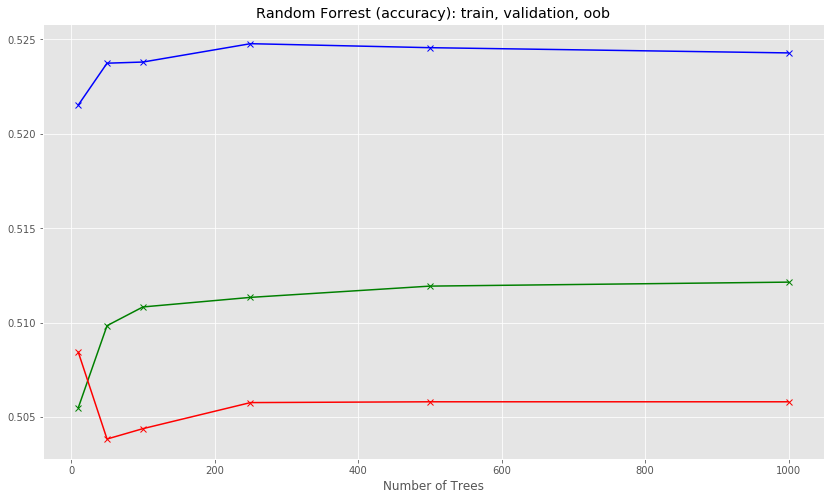

In [58]:
plt.plot(tree_sizes, train_score, 'xb-');
plt.plot(tree_sizes, oob_score, 'xg-');
plt.plot(tree_sizes, valid_score, 'xr-');
plt.title('Random Forrest (accuracy): train, validation, oob');
plt.xlabel('Number of Trees');

Nice! Our validation and OOB scores are similar.

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% en

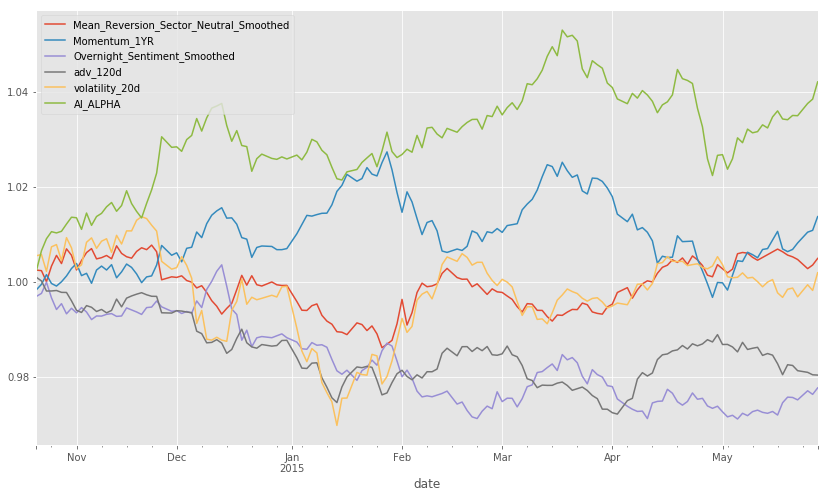

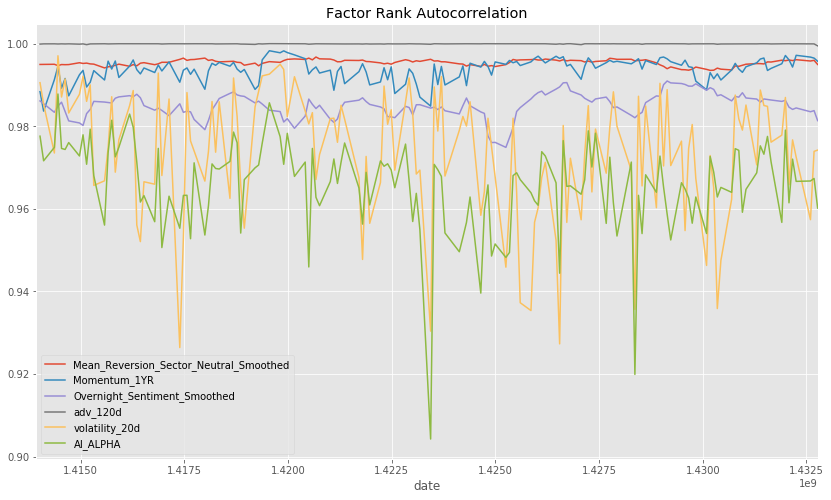

In [59]:
make_model_OOS_plots(all_factors, X_valid, clf_nov, factor_names)

## OHE Sector 

In [60]:
# Left as an exercise. :-)

# Prune Features

In [61]:
features = [
    'Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR',
    'Overnight_Sentiment_Smoothed', 'adv_120d', 'adv_20d',
    'dispersion_120d', 'dispersion_20d', 'market_vol_120d',
    'market_vol_20d', 'volatility_20d','weekday',
    'sector_code'
]

target_label = 'target'

In [73]:
X, X_train, X_valid, X_test, y_train, y_valid, y_test = make_splits(
    all_factors.reset_index(drop=True),
    features,
    target_label
)

# Final Run

In [74]:
clf = RandomForestClassifier(
        n_estimators=500,
        max_features='sqrt',
#        min_samples_leaf=5000,
        min_samples_split=20000,
        bootstrap=True,
        oob_score=True,
        n_jobs=-1,
        criterion='entropy',
        verbose=False,
        random_state=0
    )
    
clf_nov = NoOverlapVoter(clf)
clf_nov.fit(X_train, y_train)

NoOverlapVoter(base_estimator=None, overlap_increment=5)

In [75]:
t, v, o = model_score(clf_nov)

train: 0.513882, oob: 0.506542, valid: 0.506164


Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.2% en

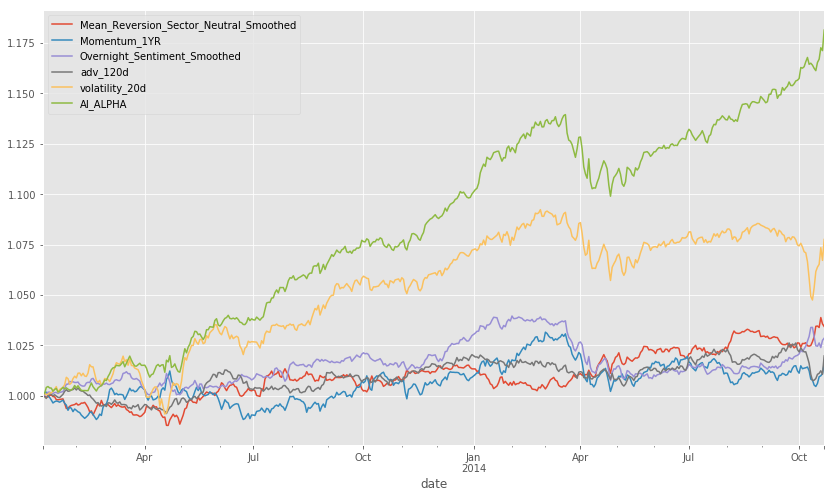

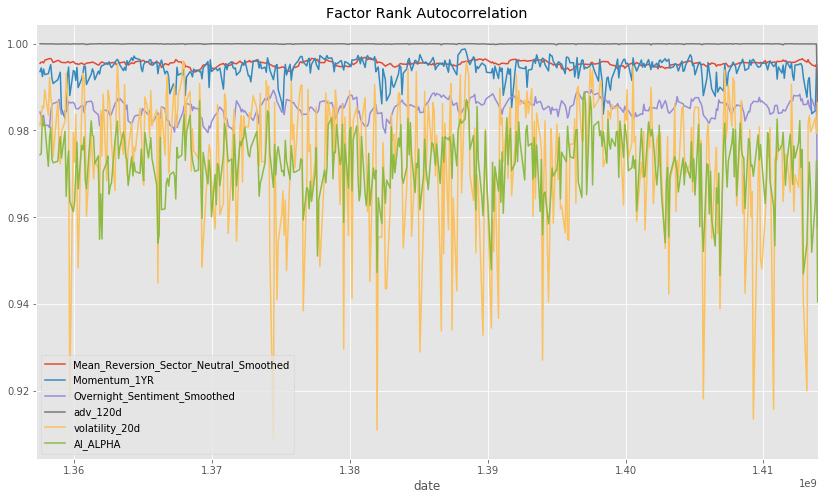

In [76]:
make_model_OOS_plots(all_factors, X_train, clf_nov, factor_names)

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% en

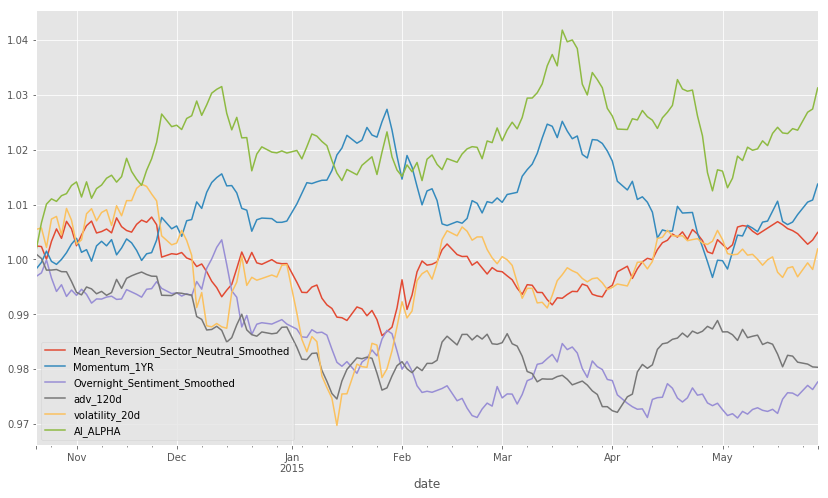

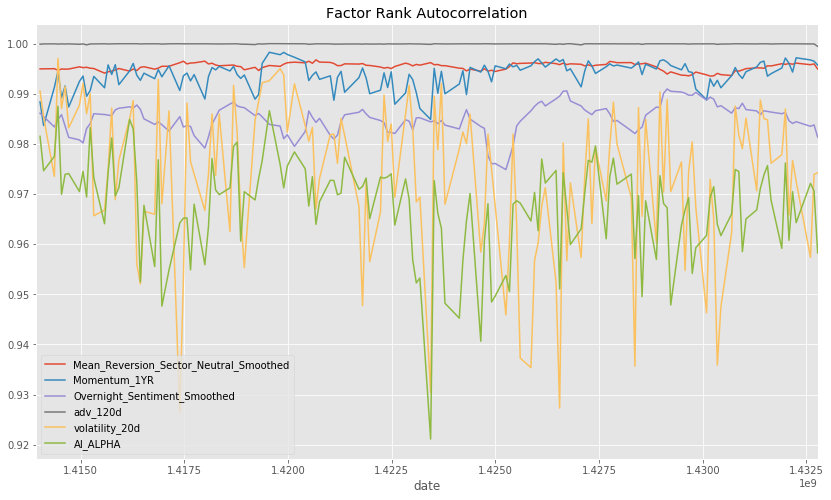

In [77]:
make_model_OOS_plots(all_factors, X_valid, clf_nov, factor_names)

# Out-of-Sample Test

And lastly, **one time only**, we look at our out-of-sample test data. Fingers crossed...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% en

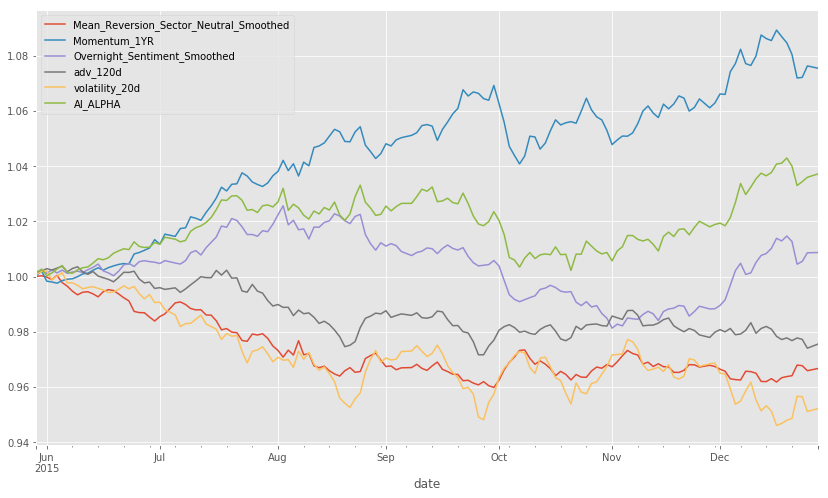

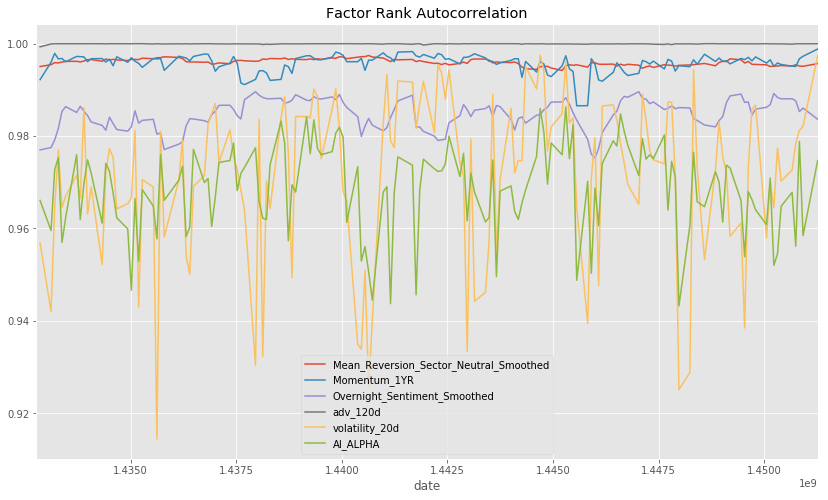

In [78]:
make_model_OOS_plots(all_factors, X_test, clf_nov, factor_names)

## Footnote: Re-Training
In production, we would roll forward the training. So the test above on the "test" set is even more conservative. Typically you would re-train up to the "current day" and then test. When we do that here, we get a slight increase in out-of-sample performace.

In [79]:
X, X_train, X_valid, X_test, y_train, y_valid, y_test = make_splits(
    all_factors.reset_index(drop=True),
    features,
    target_label,
    split_valid=0
)

In [80]:
clf = RandomForestClassifier(
        n_estimators=500,
        max_features='sqrt',
        min_samples_split=20000,
        #min_samples_leaf=5000,
        bootstrap=True,
        oob_score=False,
        n_jobs=-1,
        criterion='entropy',
        verbose=False,
        random_state=0
    )
    
clf_nov = NoOverlapVoter(clf)
clf_nov.fit(X_train, y_train)

NoOverlapVoter(base_estimator=None, overlap_increment=5)

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.0% en

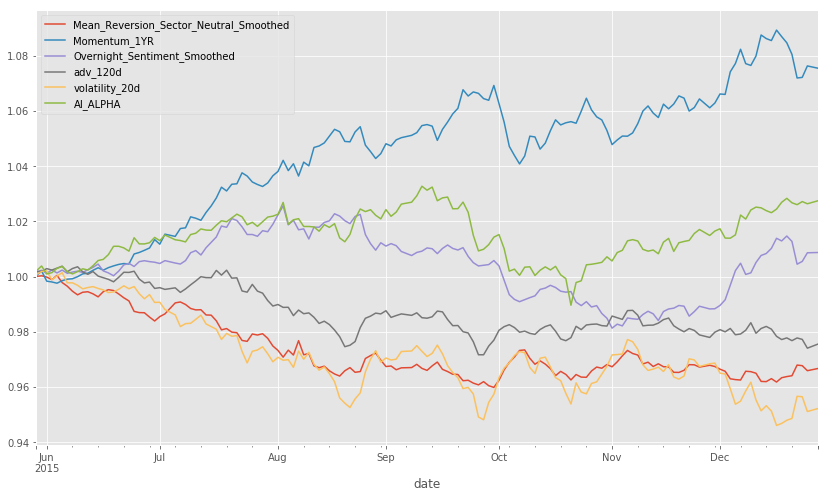

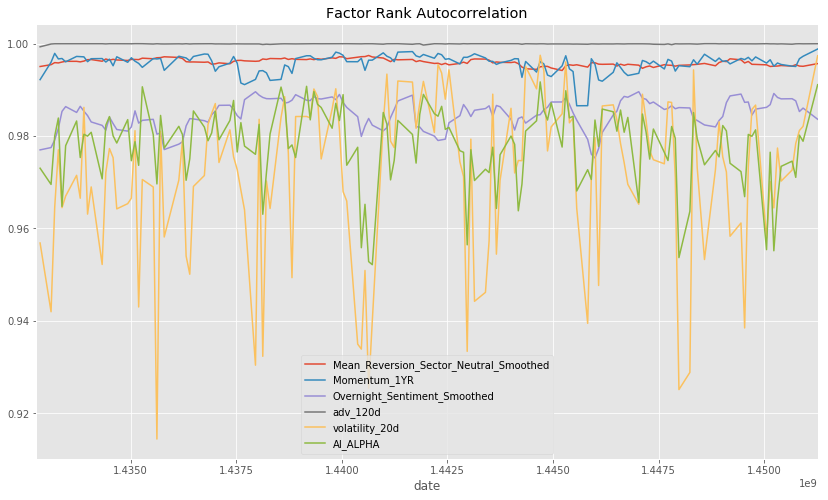

In [81]:
make_model_OOS_plots(all_factors, X_test, clf_nov, factor_names)